In [1]:
import os
import bye_cycle
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
# Disabling tf warnings
tf.get_logger().setLevel('INFO')
# Disabling GPU
RUN_ON_GPU = True
if not RUN_ON_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
dat = []
for file in os.listdir('CACHED_DATA/'):
    if file.startswith("cell"):
        with open(f'CACHED_DATA/{file}', 'rb') as f:
            cell_data = np.array(pickle.load(f))[0]
        dat.append(cell_data)
print('CACHED data is loaded.')

CACHED data is loaded.


In [4]:
import random
random.seed(0)
indices = list(range(len(dat)))
random.shuffle(indices)
train_size = 0.9
val_size = 0.09
N_train = int(train_size *len(dat))
N_val = int(val_size *len(dat))
train_dat = dat[:N_train]
# train_indices = random.sample(range(len(dat)), N_train)
test_dat = dat[N_train:]
val_dat = test_dat[:N_val]
test_dat = test_dat[N_val:]

# val_indices = random.sample(list(range(len(dat))).pop(train_indices), N_val)
# N_test = len(dat) - N_train - N_val

In [20]:
add_txt = 'hi There'
with open('CACHED_DATA/pre_processed_pandas/notes.txt', 'r+') as f:
    for line in f:
#         loglist = f.readlines()
#         print(line)
#         print(loglist)
        if add_txt not in line : 
            f.write(add_txt)

In [6]:
# data_prep
def prep_ml_data(dat, cycle_numbers=20):
    features = np.empty([0, cycle_numbers,100, 3])
    labels = np.empty([0, cycle_numbers])
    print('Generating features and labels. Skipping cells with cycles lower than 50.')
    for j,d in enumerate(tqdm(dat)):
        if not len(d) < 50:
            n = d.shape[0]//cycle_numbers
            cell_features = []
            cell_labels = []
            for i in range(n-1):
                cell_features.append(d[cycle_numbers*i:cycle_numbers*(i+1), :, :3])
                cell_labels.append(d[cycle_numbers*(i+1):cycle_numbers*(i+2), 0, -1])
#             print(np.array(cell_features).shape, j)
            features = np.append(features, np.array(cell_features), axis=0)
            labels = np.append(labels, np.array(cell_labels), axis=0)
        else:
            print(f'Cell {j} has only {len(d)} cycles. Skipping!')
    return features, labels

In [7]:
train_features, train_labels = prep_ml_data(train_dat)

Generating features and labels. Skipping cells with cycles lower than 50.


  5%|▍         | 16/339 [00:00<00:02, 159.16it/s]

Cell 8 has only 2 cycles. Skipping!


 12%|█▏        | 42/339 [00:00<00:07, 40.92it/s] 

Cell 41 has only 2 cycles. Skipping!


 39%|███▉      | 133/339 [00:11<00:28,  7.29it/s]

Cell 131 has only 48 cycles. Skipping!


 56%|█████▋    | 191/339 [00:24<00:39,  3.77it/s]

Cell 191 has only 2 cycles. Skipping!


100%|██████████| 339/339 [01:19<00:00,  4.29it/s]


In [25]:
dat[0].shape

(1431, 100, 4)

In [22]:
from beep.structure.cli import auto_load_processed
cell = auto_load_processed('/home/ec2-user/SageMaker/data_cache/structure/PreDiag_000206_000057_structured.json.gz')

In [23]:
cell.structured_summary

,cycle_index,discharge_capacity,charge_capacity,discharge_energy,charge_energy,dc_internal_resistance,temperature_maximum,temperature_average,temperature_minimum,date_time_iso,energy_efficiency,charge_throughput,energy_throughput,charge_duration,time_temperature_integrated,paused,CV_time,CV_current
0,0,4.773268,3.870386,17.471176,15.071790,0.0,NaN,NaN,NaN,2019-12-14T00:58:35+00:00,1.159197,3.870386,15.071790,NaN,NaN,62318,2084.219971,0.138476
1,6,0.000163,1.751873,0.000559,6.227764,0.0,NaN,NaN,NaN,2019-12-17T13:54:56+00:00,0.000090,5.622260,21.299555,NaN,NaN,0,1799.969971,0.124514
2,7,0.000122,0.034658,0.000421,0.128238,0.0,NaN,NaN,NaN,2019-12-17T16:21:32+00:00,0.003282,5.656918,21.427792,NaN,NaN,0,1799.979980,0.028153
3,8,0.000163,0.011033,0.000560,0.040823,0.0,NaN,NaN,NaN,2019-12-17T17:11:33+00:00,0.013708,5.667951,21.468615,NaN,NaN,0,1799.979980,0.011215
4,9,0.000163,0.005046,0.000559,0.018673,0.0,NaN,NaN,NaN,2019-12-17T18:01:34+00:00,0.029962,5.672997,21.487288,NaN,NaN,0,1799.969971,0.007324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4437,4667,0.000163,0.001382,0.000558,0.005115,0.0,NaN,NaN,NaN,2020-09-02T13:28:15+00:00,0.109117,80.722565,288.610504,NaN,NaN,0,659.969971,0.001602
4438,4668,0.000163,0.001001,0.000558,0.003704,0.0,NaN,NaN,NaN,2020-09-02T14:18:16+00:00,0.150690,80.723572,288.614197,NaN,NaN,0,810.000000,0.001831
4439,4669,0.000122,0.000846,0.000420,0.003132,0.0,NaN,NaN,NaN,2020-09-02T15:08:17+00:00,0.134067,80.724411,288.617340,NaN,NaN,0,1499.969971,0.002289
4440,4670,0.000122,0.000738,0.000420,0.002732,0.0,NaN,NaN,NaN,2020-09-02T15:58:18+00:00,0.153696,80.725151,288.620056,NaN,NaN,0,1560.000000,0.000458


In [14]:
add_txt = 'PreDiag_000255_000214_structured'
with open('CACHED_DATA/pre_processed_pandas/notes.txt', 'r+') as f:
    if add_txt in f.read():
        print('line_exists')
    else:
        print('Run')

line_exists


In [ ]:
import os
structure_path = '/home/ec2-user/SageMaker/data_cache/structure/'
#Get all structured files with the correct prefix
names = [os.path.join(structure_path, n) for n in os.listdir(structure_path) if "PreDiag" in n or "PredictionDiagnostics" in n]
#exclude stitched files
names = [n for n in names if (not "p2_structure" in n and ".gz" in n)]
from beep.structure.cli import auto_load_processed
cell = auto_load_processed(names[275])
clean_cell = bye_cycle.clean_cycle_data(cell, 0)

In [ ]:
names

In [41]:
cell.raw_data.head(10)

,data_point,cycle_index,step_index,test_time,step_time,_capacity,_energy,current,voltage,_state,...,_var13,_var14,_var15,charge_capacity,discharge_capacity,charge_energy,discharge_energy,date_time_iso,temperature,time_since_cycle_start
0,1,0,1,0.0,0.0,0.0,0.0,0.0,4.146105,R,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-19T20:18:43+00:00,NaN,0.00
1,2,0,1,30.0,30.0,0.0,0.0,0.0,4.146182,R,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-19T20:19:16+00:00,NaN,0.55
2,3,0,1,60.0,60.0,0.0,0.0,0.0,4.145953,R,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-19T20:19:43+00:00,NaN,1.00
3,4,0,1,90.0,90.0,0.0,0.0,0.0,4.145800,R,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-19T20:20:13+00:00,NaN,1.50
4,5,0,1,120.0,120.0,0.0,0.0,0.0,4.145800,R,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-19T20:20:43+00:00,NaN,2.00
5,6,0,1,150.0,150.0,0.0,0.0,0.0,4.145724,R,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-19T20:21:13+00:00,NaN,2.50
6,7,0,1,180.0,180.0,0.0,0.0,0.0,4.145800,R,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-19T20:21:43+00:00,NaN,3.00
7,8,0,1,210.0,210.0,0.0,0.0,0.0,4.145648,R,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-19T20:22:13+00:00,NaN,3.50
8,9,0,1,240.0,240.0,0.0,0.0,0.0,4.145648,R,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-19T20:22:43+00:00,NaN,4.00
9,10,0,1,270.0,270.0,0.0,0.0,0.0,4.145724,R,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-12-19T20:23:13+00:00,NaN,4.50


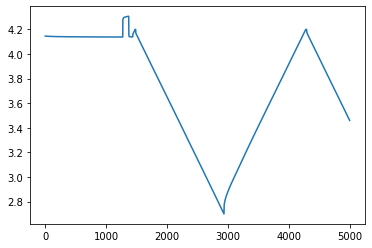

In [53]:
plt.plot(cell.raw_data.head(5000)['voltage'])

In [62]:
cell.structured_data['cycle_index']


0             0
1             0
2             0
3             0
4             0
           ... 
2863995    1513
2863996    1513
2863997    1513
2863998    1513
2863999    1513
Name: cycle_index, Length: 2864000, dtype: int32

In [67]:
cycle_index = []
time_c =[]
for i,c in enumerate(cell.structured_data['cycle_index']):
    if c not in cycle_index:
        cycle_index.append(c)
        time_c.append(i)
    

In [77]:
time_c

[0,
 1000,
 2000,
 3000,
 4000,
 5000,
 6000,
 7000,
 8000,
 9000,
 10000,
 11000,
 12000,
 13000,
 14000,
 15000,
 16000,
 17000,
 18000,
 19000,
 20000,
 21000,
 22000,
 23000,
 24000,
 25000,
 26000,
 27000,
 28000,
 29000,
 30000,
 31000,
 32000,
 33000,
 34000,
 35000,
 36000,
 37000,
 38000,
 39000,
 40000,
 41000,
 42000,
 43000,
 44000,
 45000,
 46000,
 47000,
 48000,
 49000,
 50000,
 51000,
 52000,
 53000,
 54000,
 55000,
 56000,
 57000,
 58000,
 59000,
 60000,
 61000,
 62000,
 63000,
 64000,
 65000,
 66000,
 67000,
 68000,
 69000,
 70000,
 71000,
 72000,
 73000,
 74000,
 75000,
 76000,
 77000,
 78000,
 79000,
 80000,
 81000,
 82000,
 83000,
 84000,
 85000,
 86000,
 87000,
 88000,
 89000,
 90000,
 91000,
 92000,
 93000,
 94000,
 95000,
 96000,
 97000,
 98000,
 99000,
 100000,
 101000,
 102000,
 103000,
 104000,
 105000,
 106000,
 107000,
 108000,
 109000,
 110000,
 111000,
 112000,
 113000,
 114000,
 115000,
 116000,
 117000,
 118000,
 119000,
 120000,
 121000,
 122000,
 12300

Text(0.5, 0, 'Time')

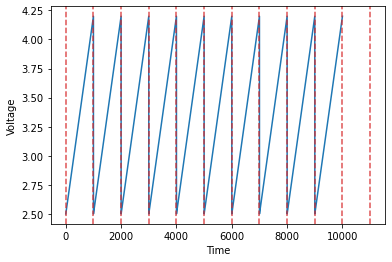

In [83]:
plt.plot(cell.structured_data.head(10000)['voltage'])
for t in time_c:
    plt.axvline(t, linestyle='--',color='C3', alpha=0.8)
    if t > 10000:
        break
plt.ylabel('Voltage')
plt.xlabel('Time')

In [87]:
cell.structured_data.iloc[-2000:]['voltage'].dropna()

2862001    3.465450
2862002    3.479265
2862003    3.489516
2862004    3.498118
2862005    3.505805
             ...   
2863073    3.782738
2863074    3.785545
2863075    3.788277
2863076    3.791022
2863077    3.793859
Name: voltage, Length: 353, dtype: float32

(1500000.0, 1510000.0)

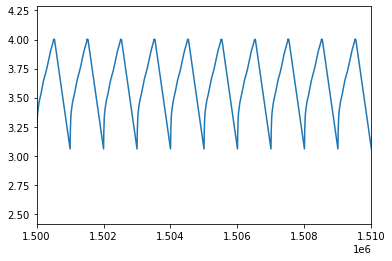

In [98]:
plt.plot(cell.structured_data['voltage'].dropna())
plt.xlim([1.5e6,1.51e6])

Text(0.5, 0, 'Time')

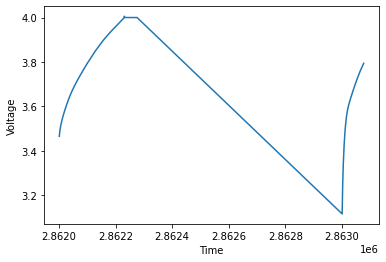

In [88]:
plt.plot(cell.structured_data.iloc[-2000:]['voltage'].dropna())
# for t in time_c:
#     if t > t[-2000]:
#         plt.axvline(t, linestyle='--',color='C3', alpha=0.8)
#         break
plt.ylabel('Voltage')
plt.xlabel('Time')

In [109]:
cell

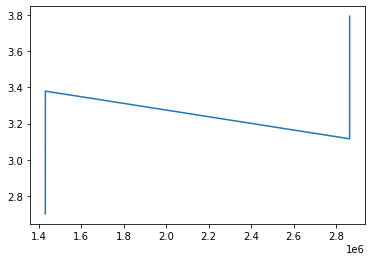

In [113]:
max_cycle_index = max(cell.structured_data['cycle_index'])
clean_cell = bye_cycle.clean_cycle_data(cell, max_cycle_index)
plt.plot(clean_cell['voltage'])

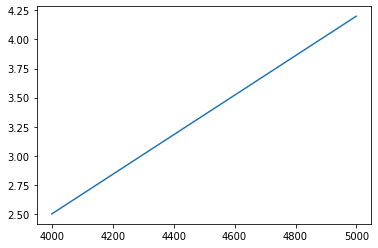

In [64]:
plt.plot(cell.structured_data.iloc[4000:5000]['voltage'])

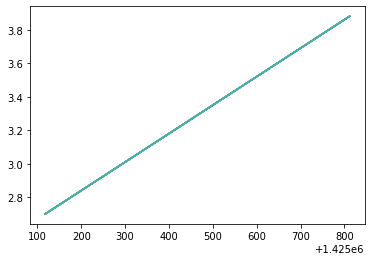

In [47]:
for i in range(10):
    clean_cell = bye_cycle.clean_cycle_data(cell, 1500)
    plt.plot(clean_cell['voltage'])

In [100]:
train_features.shape

(23103, 20, 100, 3)

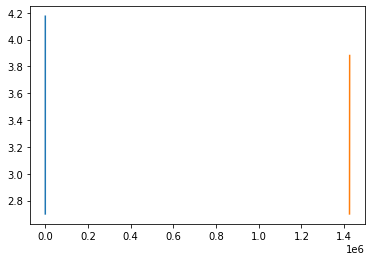

In [104]:
d = train_features[0]
plt.plot(d[0,:,0], label='interpol')
plt.plot(clean_cell['voltage'], label='raw dat')

In [8]:
val_features, val_labels = prep_ml_data(val_dat)

Generating features and labels. Skipping cells with cycles lower than 50.


100%|██████████| 33/33 [00:00<00:00, 52.75it/s] 


In [9]:
test_features, test_labels = prep_ml_data(test_dat)

Generating features and labels. Skipping cells with cycles lower than 50.


100%|██████████| 5/5 [00:00<00:00, 139.60it/s]


In [10]:
def standardize(inputs):
    fstd = np.std(inputs, axis=0)
    fmean = np.mean(inputs, axis=0)
    std_features = (inputs - fmean) / fstd
    return std_features
std_train_features = standardize(train_features)
std_test_features = standardize(test_features)
std_val_features = standardize(val_features)

In [11]:
from dataclasses import dataclass
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(train_labels), 
                batch_size=512, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

In [12]:
# [:,:,:2]
np.random.seed(0)
i = np.arange(len(train_features))
np.random.shuffle(i)
train_data = tf.data.Dataset.from_tensor_slices((std_train_features[i], train_labels[i])).batch(config.batch_size)
i = np.arange(len(val_features))
val_data = tf.data.Dataset.from_tensor_slices((std_val_features[i], val_labels[i])).batch(config.batch_size)
i = np.arange(len(test_features))
test_data = tf.data.Dataset.from_tensor_slices((std_test_features[i], test_labels[i])).batch(config.batch_size)
N = len(dat)
C = std_train_features.shape[1]
T = std_train_features.shape[2]
L = std_train_features.shape[-1]

2022-06-22 15:06:48.478875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 15:06:48.480503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 15:06:48.482104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 15:06:48.483631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 15:06:48.485203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [13]:
std_train_features.shape

(23103, 20, 100, 3)

In [14]:
def build_model(C, T, L, cycle_numbers=20):
    inputs = tf.keras.Input(shape=(C, T, L))
    print(f'input: {inputs.shape}')
    conv_1d_layer = tf.keras.layers.Conv1D(16, 100)
    blstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16))
    x = tf.keras.layers.TimeDistributed(conv_1d_layer, input_shape=(5, 3))(inputs)
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
#     x = tf.keras.layers.Reshape((100, 64))(x)
    print(f'output CNN 1: {x.shape}')
#     conv_1d_layer = tf.keras.layers.Conv1D(64, 5, input_shape=(100,64))
#     x = tf.keras.layers.TimeDistributed(conv_1d_layer, input_shape=(100,))(x)
    print(x.shape)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
#     e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
#                                     output_dim=config.embedding_dim,
#                                     mask_zero=True)(inputs)
    yhat = tf.keras.layers.Dense(cycle_numbers)(x)
    model = tf.keras.Model(inputs=[inputs], outputs=yhat)
    return model
tf.keras.backend.clear_session()
model = build_model(C, T, L)
opt = tf.optimizers.Adam(1e-3)
model.compile(
  opt,
  loss='mean_squared_error')
model.summary()

input: (None, 20, 100, 3)
output CNN 1: (None, 20, 16)
(None, 20, 16)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 100, 3)]      0         
                                                                 
 time_distributed (TimeDistr  (None, 20, 1, 16)        4816      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16)           0         
 tributed)                                                       
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                10

In [15]:
result = model.fit(
    train_data, 
    validation_data=val_data, 
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.9, patience=5, min_lr=1e-5
        ), tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=10)],
# #         tf.keras.callbacks.LambdaCallback(
# #         on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
# #         ),
#         ,
    epochs=150)

Epoch 1/150


2022-06-22 15:07:00.677405: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-06-22 15:07:01.122992: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


46/46 [==============================] - 8s 58ms/step - loss: 2.9812 - val_loss: 1.9436 - lr: 0.0010
Epoch 2/150
46/46 [==============================] - 1s 22ms/step - loss: 0.8556 - val_loss: 0.8452 - lr: 0.0010
Epoch 3/150
46/46 [==============================] - 1s 22ms/step - loss: 0.3016 - val_loss: 0.5764 - lr: 0.0010
Epoch 4/150
46/46 [==============================] - 1s 22ms/step - loss: 0.1986 - val_loss: 0.5052 - lr: 0.0010
Epoch 5/150
46/46 [==============================] - 1s 22ms/step - loss: 0.1692 - val_loss: 0.5101 - lr: 0.0010
Epoch 6/150
46/46 [==============================] - 1s 22ms/step - loss: 0.1568 - val_loss: 0.5504 - lr: 0.0010
Epoch 7/150
46/46 [==============================] - 1s 22ms/step - loss: 0.1480 - val_loss: 0.5538 - lr: 0.0010
Epoch 8/150
46/46 [==============================] - 1s 22ms/step - loss: 0.1422 - val_loss: 0.5592 - lr: 0.0010
Epoch 9/150
46/46 [==============================] - 1s 22ms/step - loss: 0.1378 - val_loss: 0.5702 - lr: 0.

Text(0.5, 0, 'Epochs')

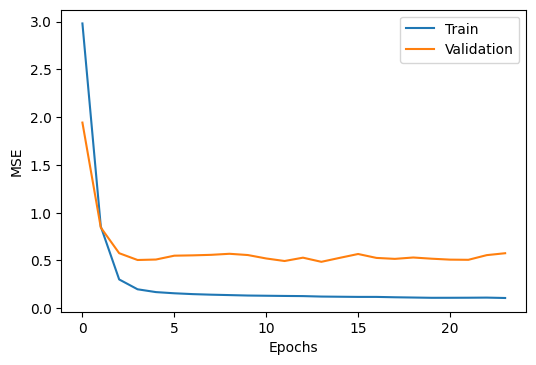

In [16]:
plt.figure(dpi=100)
plt.plot(result.history['loss'], color='C0', label='Train')
plt.plot(result.history['val_loss'], color='C1', label='Validation')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epochs')